In [1]:
# импортируем все необходимые библиотеки, будем добавлять их в это окошко по мере увеличения количества
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


In [2]:
# визуально просмотрим таблицу, ниже добавим описания столбцов
df = pd.read_csv(r'data.csv')
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


Описание данных
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

In [3]:
# проверим количество пропущенных значений в каждом столбце
df.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [4]:
# выберем числовые стобцы и посмотрим на их статистики
numeric_cols = df.select_dtypes('number')
numeric_cols_describe = numeric_cols.describe()
numeric_cols_describe


,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


<span style="font-size:150%">Начнем работу со столбцами с пропущенными значениями</span>
__________________________________________________________________________________________________


In [5]:
# Выбор только тех столбцов, которые содержат пропущенные значения

columns_with_missing_values = df.columns[df.isna().any()].tolist()
columns_with_missing_values

['days_employed', 'total_income']

In [6]:
''' 
Создадим фунцию принимающую на вход :
    data - исходную таблицу 
    col - столбец c пропусками
Функция посдсчитывает количество пропусков и общее количество записей
Ha основании полученных значений расчитывается относительное содержание пропусков по стобцу (в процентах)
'''
def relative_num_of_null(df, col):
    num_of_null = df.isnull().sum()[col]
    num_of_all = df[col].count()
    relative_null = round(100* num_of_null/num_of_all,2)
    return (f'Процентное содержание пропущенных значений в столбце {col} составляет {relative_null} %')


In [7]:
for col in columns_with_missing_values:
    print(relative_num_of_null(df, col))

Процентное содержание пропущенных значений в столбце days_employed составляет 11.23 %
Процентное содержание пропущенных значений в столбце total_income составляет 11.23 %


Пропущенные значения будем заполнять медианными значениями по столбцам.
Заполнение пропущенных значений медианным значением является одним из наиболее распространенных методов обработки пропущенных значений в количественных переменных. Это связано с тем, что медиана является устойчивой к выбросам и не искажается в отличие от среднего значения. Кроме того, заполнение пропущенных значений медианным значением может помочь сохранить распределение данных.

Существует множество причин появления пропусков в данных. Некоторые из них могут быть связаны с ошибками ввода данных, техническими проблемами при сборе данных или ошибками при обработке данных. Другие причины могут быть связаны с тем, что данные не были предоставлены или были утеряны.

In [8]:
# Напишем фунцию, заполняющую столбец с пропусками соотвествующим мединным значением
# Ее мы сможем сразу применить к столбцу total_income
def median_value_to_null(df, col):
    df[col].median()
    df[col].fillna(df[col].median(), inplace=True)


In [9]:
median_value_to_null(df, 'total_income')

In [10]:
# Проверяем, остались ли пропущенные значения
df[columns_with_missing_values].isnull().sum()

days_employed    2174
total_income        0
dtype: int64

In [11]:
# В столбце days_employed cуществуют аномалии
# Это отрицательны значения трудового стажа, что невозможно
# Убедимся в их наличии, рассмотрев статистики по столбцу 

df['days_employed'].describe(include='all')

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

In [12]:
# Посмотрим на относительно количество отрицательных занчений

num_of_negative = round(((df['days_employed'] < 0).mean() * 100),2)
print(f'Относительное количество отрицательных значений в столбце с трудовым стажем составило {num_of_negative} %') 


Относительное количество отрицательных значений в столбце с трудовым стажем составило 73.9 %


In [13]:
# Предполагаем, что отрицательные значения появились из-за лишних введенных "минусов"
# исправим это, заменой всех значений на их модули

df['days_employed'] = df['days_employed'].abs()
df['days_employed'].describe(include='all')


count     19351.000000
mean      66914.728907
std      139030.880527
min          24.141633
25%         927.009265
50%        2194.220567
75%        5537.882441
max      401755.400475
Name: days_employed, dtype: float64

In [14]:
# Создадим столбец в количеством трудового стажа в годах и посмотрим на его статистику

df['years_employed'] = df['days_employed'].apply(lambda x: x / 365.25)
df['years_employed'].describe(include = 'all')


count    19351.000000
mean       183.202543
std        380.645806
min          0.066096
25%          2.538013
50%          6.007449
75%         15.161896
max       1099.946339
Name: years_employed, dtype: float64

In [15]:
# Видим аномально большое значение
# Заменим его с учетом возраста клиента:
# Пусть все аномально большие значения (большие, чем {возраст - 18}) заменятся на медианные 

(df['years_employed']> (df['dob_years'] - 18) )

col_median = df['years_employed'].median()
df.loc[df['years_employed'] > (df['dob_years'] - 18), 'years_employed'] = col_median


In [16]:
df['years_employed'].describe(include = 'all')

count    19351.000000
mean         6.145284
std          5.291868
min          0.066096
25%          2.553541
50%          6.007449
75%          7.118563
max         44.133300
Name: years_employed, dtype: float64

In [17]:
# Повторим для столбца с количеством в днях

col_median = df['days_employed'].median()
df.loc[df['days_employed'] > (df['dob_years'] - 18)*365.25, 'days_employed'] = col_median
df['days_employed'].describe(include = 'all')


count    19351.000000
mean      2244.564881
std       1932.854859
min         24.141633
25%        932.680704
50%       2194.220567
75%       2600.055253
max      16119.687737
Name: days_employed, dtype: float64

In [18]:
# А теперь вернемся к пропущенным значениям и также заменим их медианными 

median_value_to_null(df, 'days_employed')
median_value_to_null(df, 'years_employed')

In [19]:
# Заменим вещественный тип данных в столбце total_income на целочисленный

df['total_income'] = df['total_income'].astype(int)


In [20]:
# Также наблюдаем значение -1 в графе с количеством детей, посмотрим на их количество

df['children'].value_counts()

children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: count, dtype: int64

In [21]:
# Такое небольшое количество можно заметь на медианное
col_median = df['children'].median()
df.loc[df['children'] == -1, 'children'] = col_median

<span style="font-size:150%">Работа с дубликатами</span>
____________________________________________________________________________________________

In [22]:
df.duplicated().sum()


54

In [23]:
# Получение уникальных значений во всех столбцах с нечисловыми значениями
for column in df.select_dtypes(include=['object']):
    unique_values = df[column].unique()
    print(f'Уникальные значения в столбце {column}: {unique_values} \n')

Уникальные значения в столбце education: ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень'] 

Уникальные значения в столбце family_status: ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем'] 

Уникальные значения в столбце gender: ['F' 'M' 'XNA'] 

Уникальные значения в столбце income_type: ['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете'] 

Уникальные значения в столбце purpose: ['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на

In [24]:
# Для начала приведем строки в столбце с образованием к нижнему регистру

df['education'] = df['education'].str.lower()
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [25]:
# снова проверим количество дубликатов 

df.duplicated().sum()

71

In [26]:
# Избавимся от строк-дубликатов
# drop_duplicates(keep=‘first’): этот метод оставляет только первое вхождение каждой строки и удаляет все последующие вхождения.
df.drop_duplicates(keep='first', inplace=True)


<span style="font-size:150%">Создание новых датафреймов</span>
____________________________________________________________________________________________

Создадим два новых датафрейма, в которых:
- каждому уникальному значению из education соответствует уникальное значение education_id — в первом;
- каждому уникальному значению из family_status соответствует уникальное значение family_status_id — во втором.

In [27]:
education_id = {val: i for i, val in enumerate(df['education'].unique())}
df_edu = pd.DataFrame({'education': education_id.keys(), 'education_id': education_id.values()})
df_edu

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


In [28]:
family_status_id = {val: i for i, val in enumerate(df['family_status'].unique())}
df_stat = pd.DataFrame({'family_status': family_status_id.keys(), 'family_status_id': family_status_id.values()})
df_stat

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


Удалим из исходного датафрейма столбцы education и family_status, оставив только их идентификаторы: education_id и family_status_id. 

In [29]:
df = df.drop(columns='education') 
df = df.drop(columns='family_status') 
df.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,years_employed
0,1,8437.673028,42,0,0,F,сотрудник,0,253875,покупка жилья,23.101090
1,1,4024.803754,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,11.019312
2,0,2194.220567,33,1,0,M,сотрудник,0,145885,покупка жилья,6.007449
3,3,4124.747207,32,1,0,M,сотрудник,0,267628,дополнительное образование,11.292942
4,0,2194.220567,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,6.007449


<span style="font-size:150%">Разбиение на категории по ежемесячному доходу и цели кредита</span>
____________________________________________________________________________________________

На основании диапазонов, указанных ниже, создадим столбец total_income_category с категориями:
- 0–30000 — 'E';
- 30001–50000 — 'D';
- 50001–200000 — 'C';
- 200001–1000000 — 'B';
- 1000001 и выше — 'A'.


In [30]:
df['total_income_category'] = df.apply(lambda x: 'E' if (x['total_income'] >= 0) & (x['total_income'] <= 30000) else ('D' if (x['total_income'] >= 30001) & (x['total_income'] <= 50000) else ('C' if (x['total_income'] >= 50001) & (x['total_income'] <= 200000) else ('B' if (x['total_income'] >= 200001) & (x['total_income'] <= 1000000) else 'A'))), axis=1)
df

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,total_income_category
0,1,8437.673028,42,0,0,F,сотрудник,0,253875,покупка жилья,23.101090,B
1,1,4024.803754,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,11.019312,C
2,0,2194.220567,33,1,0,M,сотрудник,0,145885,покупка жилья,6.007449,C
3,3,4124.747207,32,1,0,M,сотрудник,0,267628,дополнительное образование,11.292942,B
4,0,2194.220567,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,6.007449,C
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,1,1,F,компаньон,0,224791,операции с жильем,12.400593,B
21521,0,2194.220567,67,1,0,F,пенсионер,0,155999,сделка с автомобилем,6.007449,C
21522,1,2113.346888,38,1,1,M,сотрудник,1,89672,недвижимость,5.786028,C
21523,3,3112.481705,38,1,0,M,сотрудник,1,244093,на покупку своего автомобиля,8.521510,B


Создадим функцию, которая на основании данных из столбца purpose сформирует новый столбец purpose_category, в который войдут следующие категории:
- 'операции с автомобилем',
- 'операции с недвижимостью',
- 'проведение свадьбы',
- 'получение образования'.

In [31]:
def get_purpose_category():
    # Заменим все операции с автомобилями на строку "операция с автомобилем"
    df.loc[df['purpose'].str.contains('автомобил'), 'purpose'] = 'операция с автомобилем'

    # Заменим все операции с недвижимостью на "оперция с недвижимостью"
    # Не будем разделять на коммерческую и жилую, т.к. есть строки не содержищие информацию об этом
    df['purpose'] = df['purpose'].apply(lambda x: 'операция с недвижимостью' if re.search(r'недвижимост[а-я]*|жил[а-я]*', x) else x)

    # Повторим для свадьбы
    df['purpose'] = df['purpose'].apply(lambda x: 'проведение свадьбы' if re.search(r'свадь[а-я]', x) else x)

    # Повторим для образования
    df['purpose'] = df['purpose'].apply(lambda x: 'образование' if re.search(r'образов[а-я]', x) else x)

get_purpose_category()

In [32]:
# Проверяем уникальные значения снова 

for column in df.select_dtypes(include=['object']):
    unique_values = df[column].unique()
    print(f'Уникальные значения в столбце {column}: {unique_values} \n')

Уникальные значения в столбце gender: ['F' 'M' 'XNA'] 

Уникальные значения в столбце income_type: ['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете'] 

Уникальные значения в столбце purpose: ['операция с недвижимостью' 'операция с автомобилем' 'образование'
 'проведение свадьбы'] 

Уникальные значения в столбце total_income_category: ['B' 'C' 'D' 'E' 'A'] 



<span style="font-size:150%">Ответы на вопросы</span>

- Есть ли зависимость между количеством детей и возвратом кредита в срок?
- Есть ли зависимость между семейным положением и возвратом кредита в срок?
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- Как разные цели кредита влияют на его возврат в срок?

In [33]:
# зависимость между количеством детей и возвратом кредита в срок
children_pivot = df.pivot_table(index='children', values='debt', aggfunc='mean')
children_pivot

,debt
children,
0,0.075258
1,0.092346
2,0.094542
3,0.081818
4,0.097561
5,0.000000
20,0.105263


Эта таблица показывает зависимость между количеством детей и возвратом кредита в срок. В первом столбце указано количество детей, а во втором - процент случаев, когда заемщик не выплатил кредит в срок.

Например, строка с индексом 0 соответствует случаям, когда у заемщика нет детей. В этой строке значение второго столбца равно 0.075438, что означает, что 7.54% заемщиков без детей не выплатили кредит в срок.

Таким образом, эта таблица позволяет оценить, как количество детей влияет на вероятность возврата кредита в срок.

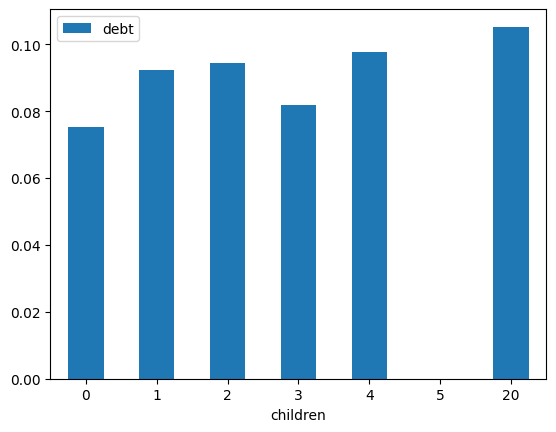

In [34]:
children_pivot.plot(kind='bar', rot=0)
plt.show()

Наблюдаем тот факт, что меньшее количество детей ведет к большей вероятности выплатить кредит в срок

In [35]:
# зависимость между семейным положением и возвратом кредита в срок
family_status_pivot = df.pivot_table(index='family_status_id', values='debt', aggfunc='mean')
family_status_pivot

,debt
family_status_id,
0,0.075452
1,0.093471
2,0.065693
3,0.071130
4,0.097509


In [36]:
df_stat

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


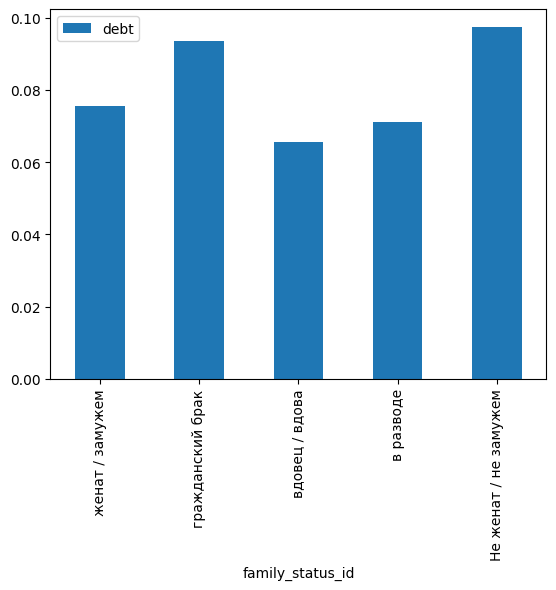

In [42]:
family_status_labels = df_stat.set_index('family_status_id')['family_status']
ax = family_status_pivot.plot(kind='bar', rot=0)
ax.set_xticklabels(family_status_labels, rotation=90)
plt.show()

Наименьшие шансы выплатить кредиты в срок набдюдаем у лиц, состоящих в гражданском браке, а также холостых граждан

In [38]:
# зависимость между уровнем дохода и возвратом кредита в срок
income_pivot = df.pivot_table(index='total_income_category', values='debt', aggfunc='mean')
income_pivot

,debt
total_income_category,
A,0.080000
B,0.070621
C,0.084915
D,0.060000
E,0.090909


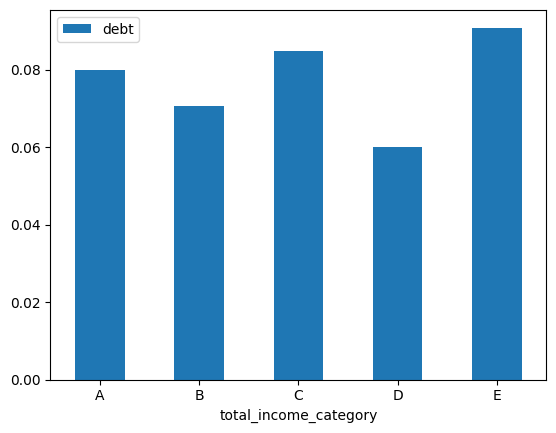

In [39]:
income_pivot.plot(kind='bar', rot=0)
plt.show()

- 0–30000 — 'E';
- 30001–50000 — 'D';
- 50001–200000 — 'C';
- 200001–1000000 — 'B';
- 1000001 и выше — 'A'

Явно можем сказать лишь, что лица с ежемесячным доходом менее 30_000 с наименьшей частотой возвращают кредиты в срок


In [40]:
# как разные цели кредита влияют на его возврат в срок
purpose_pivot = df.pivot_table(index='purpose', values='debt', aggfunc='mean')
purpose_pivot

,debt
purpose,
образование,0.092200
операция с автомобилем,0.093590
операция с недвижимостью,0.072334
проведение свадьбы,0.080034


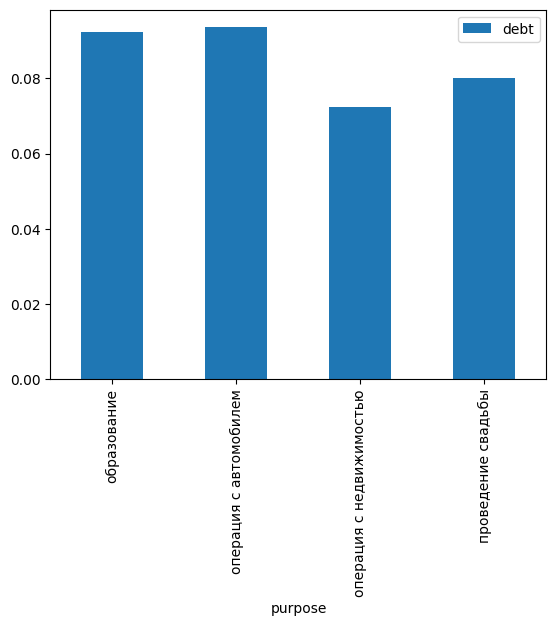

In [41]:
ax = purpose_pivot.plot(kind='bar', rot=0)
ax.set_xticklabels(purpose_pivot.index, rotation=90)
plt.show()

Ярких отличий не наблюдаем, хотя операции с недвижимостью менее всего подвержены задержкам. Предполагаем, что это связанно с коммерческой недвижимостью, за которую несется больше отвественности 